This code is experimental and provided as is. Comments can be emailed to tony.bruguier@gmail.com

You need to download your PG&E data. This is the current instructions:
https://www.pge.com/pge_global/common/pdfs/save-energy-money/analyze-your-usage/energy-data-hub/Download-My-Data-User-Guide.pdf

Be sure to use the option "Export usage for a range of days" so that you have hour-by-hour usage. There is a one-year limit so, if you want a longer period, you will have to repeat the process and concatenate the files. I have my own usage data here.

In [1]:
import csv
from datetime import (date, datetime, time)
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
usage_filename = 'pge_usage.csv'  # Point to your file that you downloaded.

usage_data = []
with open(usage_filename, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        if len(row) >= 7 and row[0] == 'Electric usage':
            d = date.fromisoformat(row[1])
            t = time.fromisoformat(row[2])
            u = float(row[4])
            usage_data.append((d, t, u,))
            
# We do not want partial months, as they mess up the analysis, so we trim the
# data to remove the first and last months of the series.
_min_year = min(x[0].year for x in usage_data)
_min_month = min(x[0].month for x in usage_data if x[0].year == _min_year)

_max_year = max(x[0].year for x in usage_data)
_max_month = max(x[0].month for x in usage_data if x[0].year == _max_year)

usage_data = [x for x in usage_data
                 if (x[0].year > _min_year or x[0].month > _min_month)
                and (x[0].year < _max_year or x[0].month < _max_month)]

# Sort the data, just in case it wasn't
usage_data = sorted(usage_data, key=lambda x: datetime.combine(x[0], x[1]))

first_date = usage_data[0][0]
last_date = usage_data[-1][0]


Now, we have parsed the data. Let's do some analysis of the usage.

Text(0.5, 1.0, 'Usage in kWh for a given month')

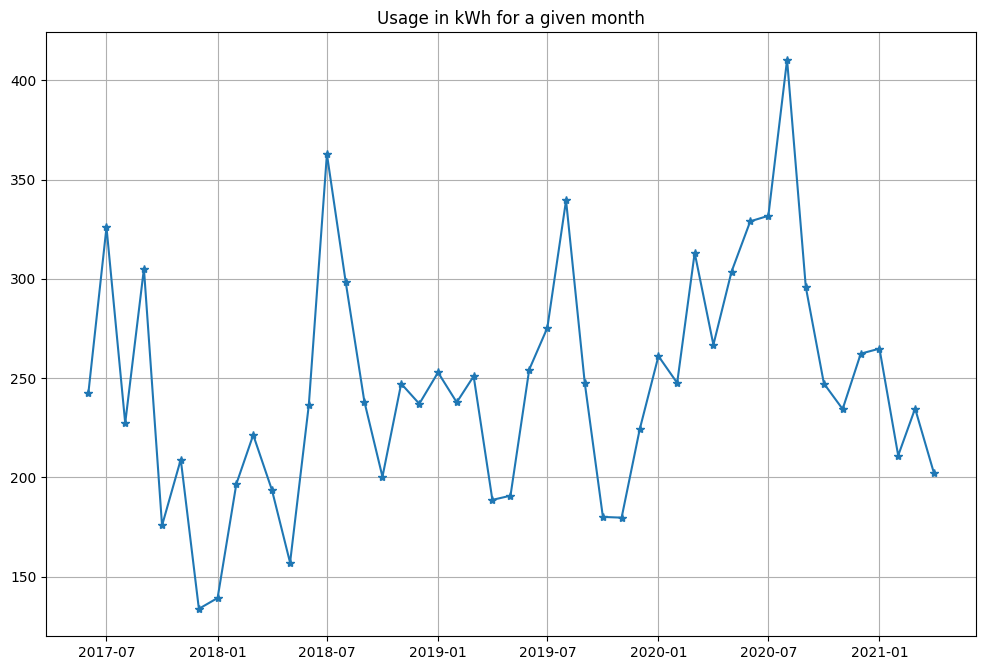

In [3]:
# Print usage by month.
xs = []
ys = []
for year in range(first_date.year, last_date.year + 1):
    for month in range(first_date.month if year == first_date.year else 1,
                       last_date.month + 1 if year == last_date.year else 12 + 1):
        xs.append(date(year, month, 1))
        ys.append(sum(x[2] for x in usage_data if x[0].year == year and x[0].month == month))

fig = plt.figure(figsize=(12, 8), dpi=100)
plt.plot_date(xs, ys, '-*')
plt.grid()
plt.title('Usage in kWh for a given month')

Text(0.5, 1.0, 'Usage in kWh for a given day, but normalized to a month')

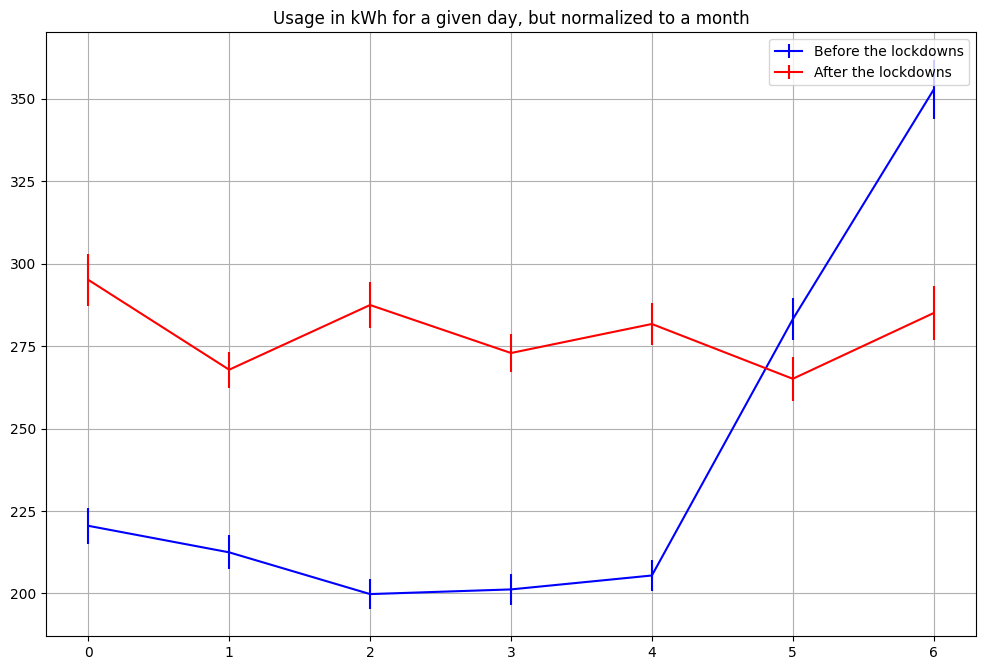

In [4]:
# Plot by day of the week, before and after the lockdowns
xs = []
ys_before = []
ys_after = []

def _renorm(x):
    return (np.average(x) * 24.0 * 365.0 / 12.0, np.std(x) * 24.0 * 365.0 / 12.0 / math.sqrt(len(x) - 1),)

for day_of_week in range(7):  # 0=Monday, 6=Sunday
    xs.append(day_of_week)
    ys_before.append(_renorm([x[2] for x in usage_data if x[0].weekday() == day_of_week and x[0] < date(2020, 3, 17)]))
    ys_after.append(_renorm([x[2] for x in usage_data if x[0].weekday() == day_of_week and x[0] >= date(2020, 3, 17)]))

fig = plt.figure(figsize=(12, 8), dpi=100)
plt.errorbar(xs, [y[0] for y in ys_before], [y[1] for y in ys_before], fmt='b')
plt.errorbar(xs, [y[0] for y in ys_after], [y[1] for y in ys_after], fmt='r')
plt.grid()

plt.legend(['Before the lockdowns', 'After the lockdowns'])
plt.title('Usage in kWh for a given day, but normalized to a month')

Text(0.5, 1.0, 'Usage in kWh for a given hour, but normalized to a month')

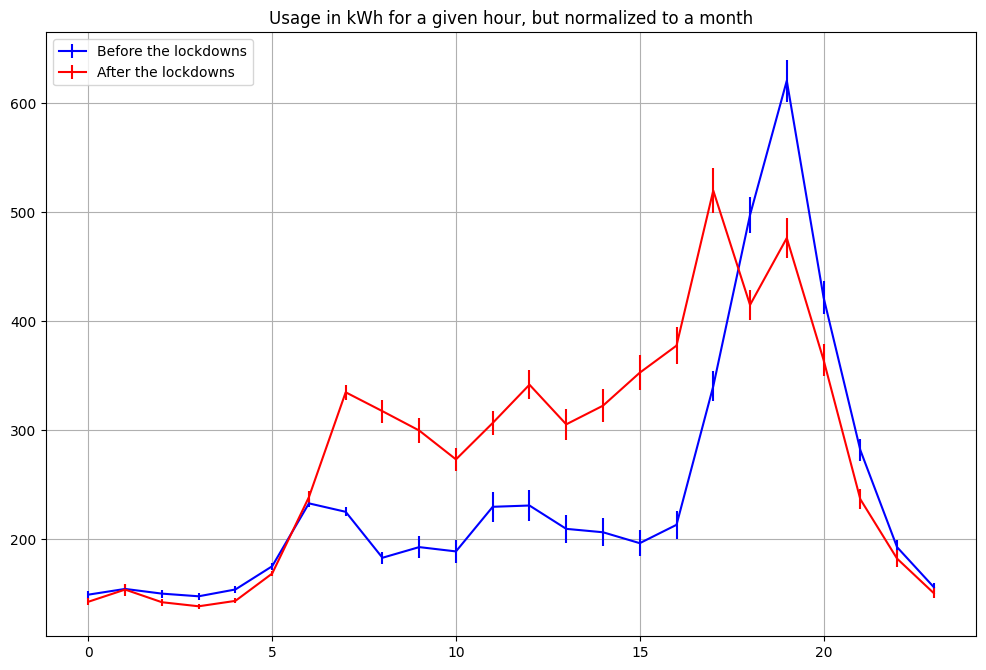

In [5]:
# Plot by hour, before and after the lockdowns
xs = []
ys_before = []
ys_after = []

def _renorm(x):
    return (np.average(x) * 24.0 * 365.0 / 12.0, np.std(x) * 24.0 * 365.0 / 12.0 / math.sqrt(len(x) - 1),)

for hour in range(24):
    xs.append(hour)
    ys_before.append(_renorm([x[2] for x in usage_data if x[1].hour == hour and x[0] < date(2020, 3, 17)]))
    ys_after.append(_renorm([x[2] for x in usage_data if x[1].hour == hour and x[0] >= date(2020, 3, 17)]))
    
fig = plt.figure(figsize=(12, 8), dpi=100)
plt.errorbar(xs, [y[0] for y in ys_before], [y[1] for y in ys_before], fmt='b')
plt.errorbar(xs, [y[0] for y in ys_after], [y[1] for y in ys_after], fmt='r')
plt.grid()

plt.legend(['Before the lockdowns', 'After the lockdowns'])
plt.title('Usage in kWh for a given hour, but normalized to a month')

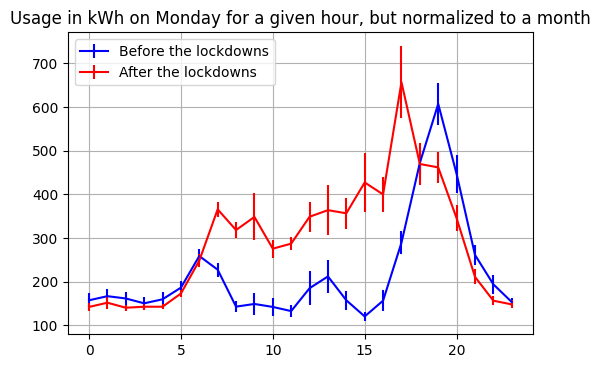

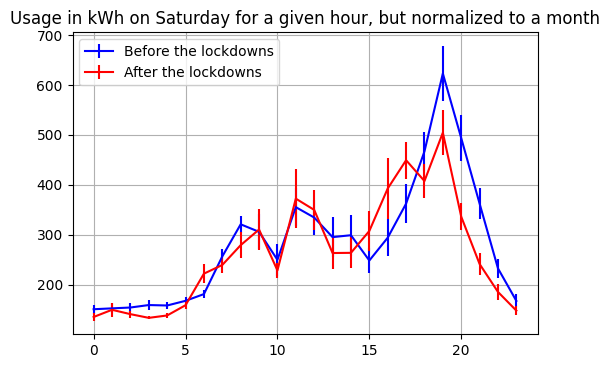

In [6]:
# Plot by hour and by day of the week, before and after the lockdowns
def _renorm(x):
    return (np.average(x) * 24.0 * 365.0 / 12.0, np.std(x) * 24.0 * 365.0 / 12.0 / math.sqrt(len(x) - 1),)

day_of_week_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day_of_week in [0, 5]:  # 0=Monday, 6=Sunday
    xs = []
    ys_before = []
    ys_after = []
    
    for hour in range(24):
        xs.append(hour)
        ys_before.append(_renorm([x[2] for x in usage_data if x[1].hour == hour and x[0].weekday() == day_of_week and x[0] < date(2020, 3, 17)]))
        ys_after.append(_renorm([x[2] for x in usage_data if x[1].hour == hour and x[0].weekday() == day_of_week and x[0] >= date(2020, 3, 17)]))
    
    fig = plt.figure(figsize=(6, 4), dpi=100)
    plt.errorbar(xs, [y[0] for y in ys_before], [y[1] for y in ys_before], fmt='b')
    plt.errorbar(xs, [y[0] for y in ys_after], [y[1] for y in ys_after], fmt='r')
    plt.grid()

    plt.legend(['Before the lockdowns', 'After the lockdowns'])
    plt.title('Usage in kWh on %s for a given hour, but normalized to a month' % (day_of_week_name[day_of_week]))